In [1]:
%cd ..
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import sys
import seaborn as sns

import functions,loading

sys.path.append(r'D:\github\neurocode\reactivation\assemblies')
import assembly

import nelpy as nel
import nelpy.plotting as npl


import itertools
import numpy as np
import os
import pandas as pd
import nelpy as nel
import multiprocessing
from joblib import Parallel, delayed
import pickle
from scipy import stats
import glob

d:\github\ripple_heterogeneity\python


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [31]:
def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat

def get_z_t(st):
    '''
    To increase the temporal resolution beyond the bin-size used to identify the assembly patterns,
    z(t) was obtained by convolving the spike-train of each neuron with a kernel-function
    '''
    # bin to 1ms
    z_t = st.bin(ds=0.001)
    # make binary
    z_t.data[z_t.data > 1] = 1
    # gaussian kernel to match the bin-size used to identify the assembly patterns
    z_t.smooth(sigma=0.025/np.sqrt(12),inplace=True)
    # zscore
    return stats.zscore(z_t.data,axis=1), z_t.bin_centers

def main_analysis(st,ripple_epochs,dt=0.025):

    binned_st = st.bin(ds=dt)
    st[~ripple_epochs].bin(ds=dt).data
    (
        patterns_outside_ripples,
        significance_outside_ripples,
        zactmat_outside_ripples
    ) = assembly.runPatterns(st[~ripple_epochs].bin(ds=dt).data)

    (
        patterns_inside_ripples,
        significance_inside_ripples,
        zactmat_inside_ripples
    ) = assembly.runPatterns(st[ripple_epochs].bin(ds=dt).data)

    results = {}
    results['patterns_outside_ripples'] = patterns_outside_ripples
    results['significance_outside_ripples'] = significance_outside_ripples
    results['zactmat_outside_ripples'] = zactmat_outside_ripples

    results['patterns_inside_ripples'] = patterns_inside_ripples
    results['significance_inside_ripples'] = significance_inside_ripples
    results['zactmat_inside_ripples'] = zactmat_inside_ripples

    return results

def session_loop(basepath,save_path):

    save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.pkl')
    if os.path.exists(save_file):
        return

    cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

    restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                        ((cell_metrics.brainRegion=="CA1") |
                        (cell_metrics.brainRegion=="rCA1") |
                        (cell_metrics.brainRegion=="lCA1")) &
                        (cell_metrics.bad_unit==False))

    # restrict cell metrics                      
    cell_metrics = cell_metrics[restrict_idx]

    if cell_metrics.shape[0] == 0:
        return
        
    # get ripple epochs
    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
    st = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)

    results = main_analysis(st,ripple_epochs)

    results['UID'] = cell_metrics.UID
    results['basepath'] = basepath
    results['deepSuperficial'] = cell_metrics.deepSuperficial

    # save file
    with open(save_file, 'wb') as f:
        pickle.dump(results, f)

def assembly_run(df,save_path,parallel=True):
    # find sessions to run
    basepaths = pd.unique(df.basepath)

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    if parallel:
        num_cores = multiprocessing.cpu_count()         
        processed_list = Parallel(n_jobs=num_cores)(delayed(session_loop)(basepath,save_path) for basepath in basepaths)
    else:    
        for basepath in basepaths:
            print(basepath)
            session_loop(basepath,save_path)   

In [32]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly'
assembly_run(df,save_path,parallel=False)

Z:\Data\AYAold\AB1\day1
Z:\Data\AYAold\AB3\AB3_38_41
Z:\Data\AYAold\AB3\AB3_42_46
Z:\Data\AYAold\AB3\AB3_47_49
Z:\Data\AYAold\AB3\AB3_50_51
Z:\Data\AYAold\AB3\AB3_55_57
Z:\Data\AYAold\AB3\AB3_58_59
Z:\Data\AYAold\AB3\AB3_60
Z:\Data\AYAold\AB4\day03
Z:\Data\AYAold\AB4\day07
Z:\Data\AYAold\AB4\day08
Z:\Data\AYAold\AB4\day09
Z:\Data\AYAold\AB4\day11
Z:\Data\AYAold\AYA10\day25
Z:\Data\AYAold\AYA10\day27
Z:\Data\AYAold\AYA10\day31
Z:\Data\AYAold\AYA10\day32
Z:\Data\AYAold\AYA10\day34
Z:\Data\AYAold\AYA4\day150726
Z:\Data\AYAold\AYA4\day150728
Z:\Data\AYAold\AYA4\day150804
Z:\Data\AYAold\AYA6\day17
Z:\Data\AYAold\AYA6\day19
Z:\Data\AYAold\AYA6\day20
Z:\Data\AYAold\AYA7\day19
Z:\Data\AYAold\AYA7\day20
Z:\Data\AYAold\AYA7\day22
Z:\Data\AYAold\AYA7\day24
Z:\Data\AYAold\AYA7\day25
Z:\Data\AYAold\AYA7\day27
Z:\Data\AYAold\AYA7\day30
Z:\Data\AYAold\AYA9\day12
Z:\Data\AYAold\AYA9\day15
Z:\Data\AYAold\AYA9\day16
Z:\Data\AYAold\AYA9\day17
Z:\Data\AYAold\AYA9\day20
Z:\Data\GirardeauG\Rat08\Rat08-20130

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:1765: UserWarning: interval duration is less than bin size: ignoring...


Z:\Data\GirardeauG\Rat10\Rat10-20140620
Z:\Data\GirardeauG\Rat10\Rat10-20140622
Z:\Data\GirardeauG\Rat10\Rat10-20140624
Z:\Data\GirardeauG\Rat10\Rat10-20140626
Z:\Data\GirardeauG\Rat10\Rat10-20140627
Z:\Data\GirardeauG\Rat10\Rat10-20140628
Z:\Data\GirardeauG\Rat10\Rat10-20140629
Z:\Data\GirardeauG\Rat10\Rat10-20140701
Z:\Data\GirardeauG\Rat10\Rat10-20140702
Z:\Data\GirardeauG\Rat10\Rat10-20140703
Z:\Data\GirardeauG\Rat10\Rat10-20140704
Z:\Data\GirardeauG\Rat10\Rat10-20140705
Z:\Data\GirardeauG\Rat10\Rat10-20140707
Z:\Data\GirardeauG\Rat10\Rat10-20140708
Z:\Data\GirardeauG\Rat11\Rat11-20150310


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:1765: UserWarning: interval duration is less than bin size: ignoring...


Z:\Data\GirardeauG\Rat11\Rat11-20150312
Z:\Data\GirardeauG\Rat11\Rat11-20150313


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:1765: UserWarning: interval duration is less than bin size: ignoring...


Z:\Data\GirardeauG\Rat11\Rat11-20150314
Z:\Data\GirardeauG\Rat11\Rat11-20150315


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:1765: UserWarning: interval duration is less than bin size: ignoring...


Z:\Data\GirardeauG\Rat11\Rat11-20150316


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:1765: UserWarning: interval duration is less than bin size: ignoring...


Z:\Data\GirardeauG\Rat11\Rat11-20150317
Z:\Data\GirardeauG\Rat11\Rat11-20150318
Z:\Data\GirardeauG\Rat11\Rat11-20150319
Z:\Data\GirardeauG\Rat11\Rat11-20150321
Z:\Data\GirardeauG\Rat11\Rat11-20150323
Z:\Data\GirardeauG\Rat11\Rat11-20150325
Z:\Data\GirardeauG\Rat11\Rat11-20150326


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:1765: UserWarning: interval duration is less than bin size: ignoring...


Z:\Data\GirardeauG\Rat11\Rat11-20150327


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:1765: UserWarning: interval duration is less than bin size: ignoring...


Z:\Data\GirardeauG\Rat11\Rat11-20150328


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:1765: UserWarning: interval duration is less than bin size: ignoring...


Z:\Data\GirardeauG\Rat11\Rat11-20150330


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:1765: UserWarning: interval duration is less than bin size: ignoring...


Z:\Data\GirardeauG\Rat11\Rat11-20150331


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [9]:
sessions = glob.glob(save_path +os.sep+ '*.pkl')

# for session in sessions:
#     with open(session, 'rb') as f:
#         results = pickle.load(f)

In [14]:
session = sessions[0]
with open(session, 'rb') as f:
    results = pickle.load(f)
results.keys()

dict_keys(['patterns_outside_ripples', 'significance_outside_ripples', 'zactmat_outside_ripples', 'patterns_inside_ripples', 'significance_inside_ripples', 'zactmat_inside_ripples', 'UID', 'basepath', 'deepSuperficial'])

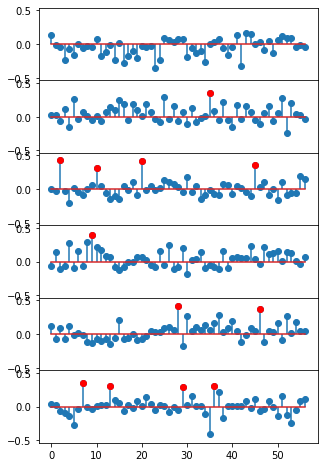

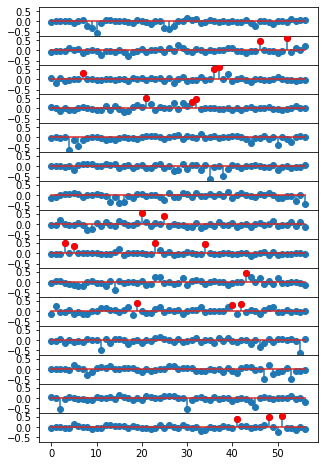

In [27]:
# results['patterns_outside_ripples'].shape
# results['patterns_inside_ripples'].shape
# sns.heatmap(results['patterns_outside_ripples'])
# plt.show()
# sns.heatmap(results['patterns_inside_ripples'])

def plot_lolipop(patterns):
    fig, axs = plt.subplots(patterns.shape[0],1, figsize=(5, 8), edgecolor='k')
    fig.subplots_adjust(hspace = 0.00, wspace=0)
    axs = axs.ravel()

    for i,assmbl in enumerate(patterns):
        axs[i].stem(np.arange(len(assmbl)),assmbl)
        thres = np.mean(assmbl) + np.std(assmbl)*2
        idx = assmbl > thres
        axs[i].scatter(np.arange(len(assmbl))[idx],assmbl[idx],color='red',zorder=1000)
        
    for i in range(patterns.shape[0]):
        axs[i].set_ylim(-patterns.max()-.1,patterns.max()+.1)
        # axs[i].axis('off')

plot_lolipop(results['patterns_inside_ripples'])        
plot_lolipop(results['patterns_outside_ripples']) 
# plt.gca().invert_yaxis()

In [120]:



# get smooth vector-function containing each neuron's z-scored instantaneous FR
z_t, ts = get_z_t(st)

In [121]:
patterns, significance, zactmat = assembly.runPatterns(binned_st.data)
assemblyAct = assembly.computeAssemblyActivity(patterns, z_t)

In [122]:
assembly_act = nel.AnalogSignalArray(data=assemblyAct,timestamps=ts,fs=1000)

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.


<AxesSubplot:>

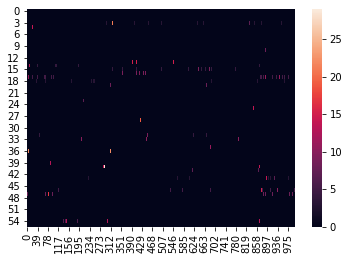

In [123]:
sns.heatmap(zactmat[:,0:1000])

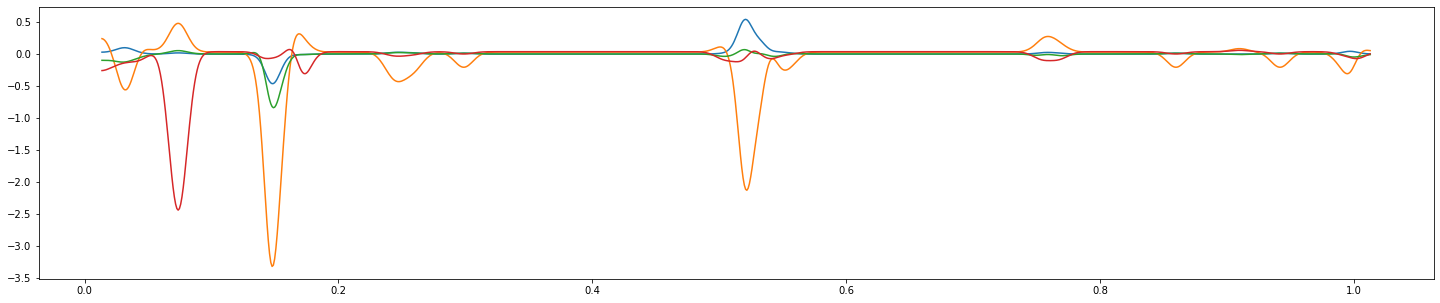

In [124]:
plt.figure(figsize=(25,5))
plt.plot(ts[0:1000],assemblyAct[0,0:1000])
plt.plot(ts[0:1000],assemblyAct[1,0:1000])
plt.plot(ts[0:1000],assemblyAct[2,0:1000])
plt.plot(ts[0:1000],assemblyAct[3,0:1000])
plt.show()

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


AttributeError: 'Line2D' object has no property 'cmap'

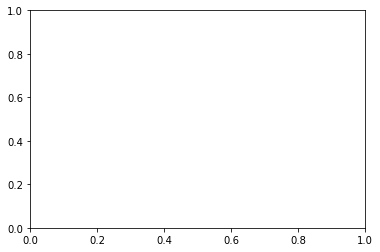

In [58]:
rip_n = 4
cmap = matplotlib.cm.get_cmap('tab20b',patterns.shape[0])

plt.plot(assembly_act[ripple_epochs[rip_n]].abscissa_vals ,assembly_act[ripple_epochs[rip_n]].data.T,cmap=cmap)
plt.show()
# plt.eventplot(st[ripple_epochs[4]].data)
# plt.show()

import matplotlib


thres = patterns.mean(axis=1) + patterns.std(axis=1)
temp_pattens = patterns.copy()
temp_pattens[patterns <  thres[:,np.newaxis]] = 0
assmbl_unit_id = temp_pattens.argmax(axis=0)

axs = plt.gca()
color_idx = 0
for i,unit_id in enumerate(pd.unique(assmbl_unit_id)):
    npl.rasterplot(st[ripple_epochs[rip_n]][:,np.where(assmbl_unit_id == unit_id)[0]+1],color=cmap(color_idx), lw=2, lh=1, ax=axs, vertstack=True)
    axs.plot(assembly_act[ripple_epochs[rip_n]].abscissa_vals,assembly_act[ripple_epochs[rip_n]].data[unit_id,:]+10*i, color=cmap(color_idx),linewidth=.75,zorder=1000-i,alpha=1)
    color_idx+=1

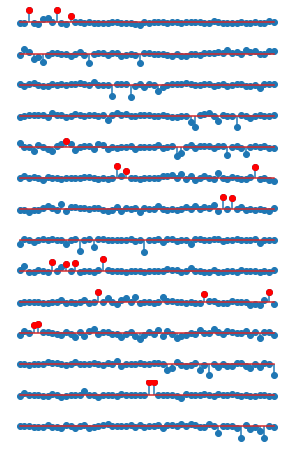

In [125]:
fig, axs = plt.subplots(patterns.shape[0],1, figsize=(5, 8), edgecolor='k')
fig.subplots_adjust(hspace = 0.00, wspace=0)
axs = axs.ravel()

for i,assmbl in enumerate(patterns):
    axs[i].stem(np.arange(len(assmbl)),assmbl)
    thres = np.mean(assmbl) + np.std(assmbl)*2
    idx = assmbl > thres
    axs[i].scatter(np.arange(len(assmbl))[idx],assmbl[idx],color='red',zorder=1000)
    
for i in range(patterns.shape[0]):
    axs[i].set_ylim(-patterns.max()-.1,patterns.max()+.1)
    axs[i].axis('off')

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


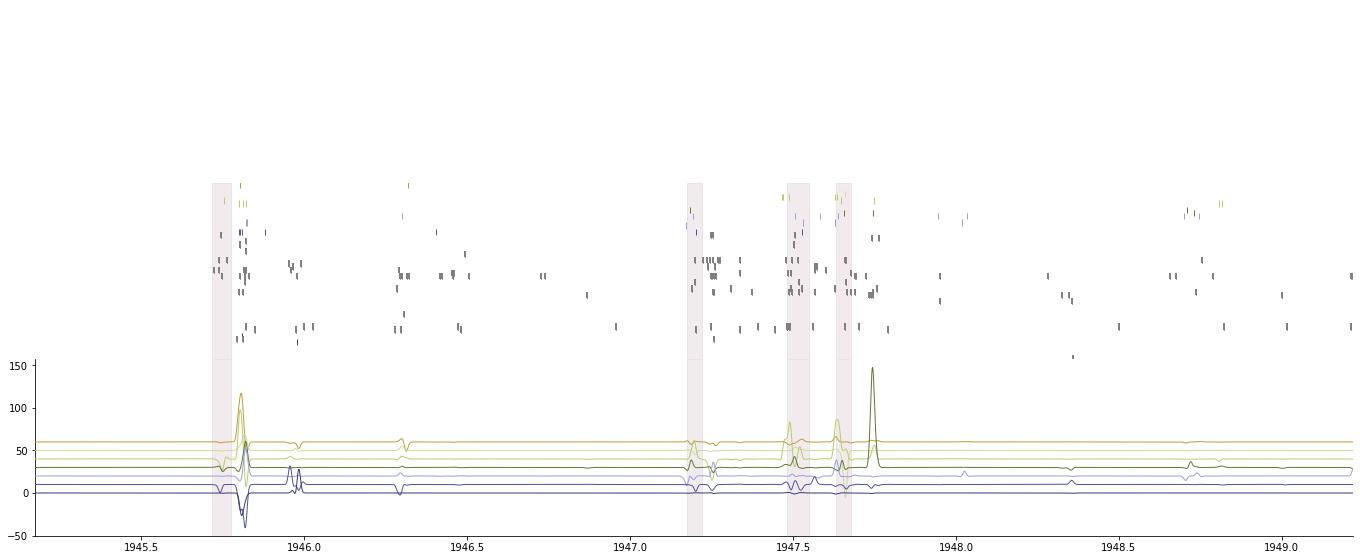

In [136]:
def plot_assembl_strength(st,patterns,assembly_act,interval,axs,show_not_in_assmbl=True,vertstack=True):
    
    cmap = matplotlib.cm.get_cmap('tab20b',patterns.shape[0])

    interval = nel.EpochArray(interval)
    st = st[interval]

    assembly_act = assembly_act[interval]
    
    thres = patterns.mean(axis=1) + patterns.std(axis=1)*2
    temp_pattens = patterns.copy()
    temp_pattens[patterns <  thres[:,np.newaxis]] = 0
    assmbl_unit_id = temp_pattens.argmax(axis=0)
    
    color_idx = 0
    for i,unit_id in enumerate(pd.unique(assmbl_unit_id)):
        npl.rasterplot(st[:,np.where(assmbl_unit_id == unit_id)[0]+1],color=cmap(color_idx), lw=1, lh=2, ax=axs[1], vertstack=vertstack)
        axs[2].plot(assembly_act.abscissa_vals,assembly_act.data[unit_id,:]+10*i, color=cmap(color_idx),linewidth=1,zorder=1000-i,alpha=1,label='assembly:'+str(unit_id))
        color_idx+=1
        
    npl.rasterplot(st[:,np.where(temp_pattens.max(axis=0) == 0)[0]+1],color='grey', lw=2, lh=2, ax=axs[1], vertstack=True)

    axs[1].set_xlim(interval.data[0][0],interval.data[0][1])
    axs[2].set_xlim(interval.data[0][0],interval.data[0][1])
    axs[1].axis('off')
    axs[2].spines["right"].set_visible(False)
    axs[2].spines["top"].set_visible(False)

fig, axs = plt.subplots(3,1, figsize=functions.set_size('thesis', fraction=4, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0)
axs = axs.ravel()  

rip_n = 201
interval = [ripple_epochs[rip_n].start-2, ripple_epochs[rip_n].stop+2]

plot_assembl_strength(st,patterns,assembly_act,interval,axs,show_not_in_assmbl=False,vertstack=True)

axs[0].axis('off')

for item in ripples[ripples['peaks'].between(interval[0], interval[1])].itertuples():
    axs[1].axvspan(item.start, item.stop, alpha=0.1, color='#843b62', zorder=-2000)
    axs[2].axvspan(item.start, item.stop, alpha=0.1, color='#843b62', zorder=-2000)

# axs[2].legend()

In [ ]:
assembl_strength = []
assembl_frac = []

for ripple in ripples.itertuples():
    # pull out current assembly based on ripple width
    curr_assembl = assemblyAct[:,(ts >= ripple.start_time) & (ts <= ripple.end_time)]
    # Assembly strength during SPW-R periods
    assembl_strength.append(np.median(curr_assembl.max(axis=0)[curr_assembl.max(axis=0) > 5]))
    
    # fraction of active assemblies active during SPW-R 
    assembl_frac.append(sum(np.any(curr_assembl > 5,axis=1)) / curr_assembl.shape[0])

n_assembl = (patterns.shape[0])
n_units = (patterns.shape[1])
n_assembl_n_cell_frac = (patterns.shape[0]/patterns.shape[1])    

# number of cells that contribute significantly (>2 SD) to each assembly     
n_cells_per_assembl_ = np.sum(patterns > (patterns.mean(axis=1) + patterns.std(axis=1)*2)[:, np.newaxis],axis=1)
n_cells_per_assembl = (n_cells_per_assembl_[n_cells_per_assembl_ > 0].mean())  